# **Homework 5 - Sequence-to-sequence**

If you have any questions, feel free to email us at: ntu-ml-2021spring-ta@googlegroups.com

### (4/21 Updates)
1. Link to reference [training curves](https://wandb.ai/george0828zhang/hw5.seq2seq.new).

### (4/14 Updates) 
1. Link to tutorial video [part 1](https://youtu.be/1pjS5_L5REI) [part 2](https://youtu.be/3XX9d0ymKgQ).
2. Now defaults to load `"avg_last_5_checkpoint.pt"` to generate prediction.
3. Expected run time on Colab with Tesla T4

|Baseline|Details|Total Time|
|-|:-:|:-:|
|Simple|2m 15s $\times$30 epochs|1hr 8m|
|Medium|4m $\times$30 epochs|2hr|
|Strong|8m $\times$30 epochs (backward)<br>+1hr (back-translation)<br>+15m $\times$30 epochs (forward)|12hr 30m|

# Sequence-to-Sequence Introduction
- Typical sequence-to-sequence (seq2seq) models are encoder-decoder models, which usually consists of two parts, the encoder and decoder, respectively. These two parts can be implemented with recurrent neural network (RNN) or transformer, primarily to deal with input/output sequences of dynamic length.
- **Encoder** encodes a sequence of inputs, such as text, video or audio, into a single vector, which can be viewed as the abstractive representation of the inputs, containing information of the whole sequence.
- **Decoder** decodes the vector output of encoder one step at a time, until the final output sequence is complete. Every decoding step is affected by previous step(s). Generally, one would add "< BOS >" at the begining of the sequence to indicate start of decoding, and "< EOS >" at the end to indicate end of decoding.

![seq2seq](https://i.imgur.com/0zeDyuI.png)

# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

# Download and import required packages

In [ ]:
'''
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets
'''

"\n!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb\n!pip install --upgrade jupyter ipywidgets\n"

In [ ]:
'''
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/
'''

'\n!git clone https://github.com/pytorch/fairseq.git\n!cd fairseq && git checkout 9a1c497\n!pip install --upgrade ./fairseq/\n'

In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 23 14:13:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
| 25%   31C    P8     2W / 250W |     67MiB / 11018MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [ ]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset Information

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

# Dataset Download

## Install megatools (optional)

In [ ]:
#!apt-get install megatools

## Download and extract

In [ ]:
'''
data_dir = './Data/rawdata'
dataset_name = 'ted2020'
urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A"', 
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214987&authkey=AA4qP_azsicwZZM"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted2020.tgz",
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/test.tgz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U",
#     "https://mega.nz/#!zNcnGIoJ!oPJX9AvVVs11jc0SaK6vxP_lFUNTkEcK2WbxJpvjU5Y",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}
'''

'\ndata_dir = \'./Data/rawdata\'\ndataset_name = \'ted2020\'\nurls = (\n    \'"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A"\', \n    \'"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214987&authkey=AA4qP_azsicwZZM"\',\n# # If the above links die, use the following instead. \n#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted2020.tgz",\n#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/test.tgz",\n# # If the above links die, use the following instead. \n#     "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U",\n#     "https://mega.nz/#!zNcnGIoJ!oPJX9AvVVs11jc0SaK6vxP_lFUNTkEcK2WbxJpvjU5Y",\n)\nfile_names = (\n    \'ted2020.tgz\', # train & dev\n    \'test.tgz\', # test\n)\nprefix = Path(data_dir).absolute() / dataset_name\n\nprefix.mkdir(parents=True, exist_ok=True)\nfor u, f in zip(urls, file_names):\n    path = prefix/f\n    if not path.exists():\n  

## Language

In [ ]:
data_dir = Path('/home/siensien/hw5/')
dataset_name = 'hw5_data'
prefix = Path(data_dir).absolute() / dataset_name

src_lang = 'zh'
tgt_lang = 'en'
data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'


In [ ]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！
Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.


## Preprocess files

In [ ]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar) #return unicode 0-65535
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip() # remove space , /n at first and end
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1) # fullwidth to halfwidth
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [ ]:
clean_corpus(prefix/data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/home/siensien/hw5/hw5_data/train_dev.raw.clean.zh & en exists. skipping clean.
/home/siensien/hw5/hw5_data/test.raw.clean.zh & en exists. skipping clean.


In [ ]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !
Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .


## Split into train/valid

In [ ]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [ ]:
#separate training and validation data
if (prefix /f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.

Out of vocabulary : Word is not shown in training data but shown in testing data

- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package  : subword tokenizer
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [ ]:
# output spm8000.model & spm8000.vocab
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/home/siensien/hw5/hw5_data/spm8000.model exists. skipping spm_train.


In [ ]:
#output tokenized files : test/train/valid . en/zh
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/home/siensien/hw5/hw5_data/train.zh exists. skipping spm_encode.
/home/siensien/hw5/hw5_data/train.en exists. skipping spm_encode.
/home/siensien/hw5/hw5_data/valid.zh exists. skipping spm_encode.
/home/siensien/hw5/hw5_data/valid.en exists. skipping spm_encode.
/home/siensien/hw5/hw5_data/test.zh exists. skipping spm_encode.
/home/siensien/hw5/hw5_data/test.en exists. skipping spm_encode.


In [ ]:
!head {'./hw5_data'+'/train.'+src_lang} -n 5
!head {'./hw5_data'+'/train.'+tgt_lang} -n 5


▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!
▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.


## Binarize the data with fairseq

In [ ]:
#transform character to binary to data-bin/dataset_name
binpath = Path('/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data')
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python3 -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data exists, will not overwrite!


# Configuration for Experiments

In [ ]:
config = Namespace(
    datadir = '/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data',
    savedir = "./checkpoints/transformer_Reverse",
    source_lang = "zh",
    target_lang = "en",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search : candidates
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging, default = false
    use_wandb=False,
)




# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [ ]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environment

In [ ]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2022-04-23 14:13:11 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2022-04-23 14:13:11 | INFO | fairseq.utils | rank   0: capabilities =  7.5  ; total memory = 10.760 GB ; name = NVIDIA GeForce RTX 2080 Ti              
2022-04-23 14:13:11 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [ ]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-04-23 14:13:11 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types
2022-04-23 14:13:11 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types


In [ ]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-04-23 14:13:11 | INFO | hw5.seq2seq | loading data for epoch 1
2022-04-23 14:13:11 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/train.zh-en.zh
2022-04-23 14:13:11 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/train.zh-en.en
2022-04-23 14:13:11 | INFO | fairseq.tasks.translation | /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data train zh-en 390041 examples
2022-04-23 14:13:11 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/valid.zh-en.zh
2022-04-23 14:13:11 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/valid.zh-en.en
2022-04-23 14:13:11 | INFO | fairseq.tasks.translation | /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data valid zh-en 3939 examples


In [ ]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([ 140,  690,   28,  270,   45,  151, 1142,  660,  606,  369, 3114, 2434,
        1434,  192,    2]),
 'target': tensor([  18,   14,    6, 2234,   60,   19,   80,    5,  256,   16,  405, 1407,
        1706,    7,    2])}
'Source: 這實在就是我所做的--光學操控思想'
"Target: that's exactly what i do optical mind control ."


## Dataset Iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```


In [ ]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2022-04-23 14:13:11 | WARNING | fairseq.tasks.fairseq_task | 2,532 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[3525, 527, 1633, 76, 2861, 2415, 2890, 210, 880, 636]


{'id': tensor([963]),
 'nsentences': 1,
 'ntokens': 18,
 'net_input': {'src_tokens': tensor([[   1,    1,    1,    1,    1,    1,    1,    5,  971, 1132,  373,  160,
            516,  315,  433,   33,    5, 3673, 2044,  339,  230,  102,  976,    2]]),
  'src_lengths': tensor([17]),
  'prev_output_tokens': tensor([[   2,  554,   36,   38,    7,   55,   24,  155,    4,  278,  407, 1362,
             26, 1011,   25,  153, 2055,    7,    1,    1,    1,    1,    1,    1]])},
 'target': tensor([[ 554,   36,   38,    7,   55,   24,  155,    4,  278,  407, 1362,   26,
          1011,   25,  153, 2055,    7,    2,    1,    1,    1,    1,    1,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [ ]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [ ]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [ ]:
# # HINT: transformer architecture included from fairseq
from fairseq.models.transformer import (
     TransformerEncoder, 
     TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration
reference implementation

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [ ]:
# you can adjust here to fine tune the performance
# enlarge bigger than reference
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=1024,
    encoder_layers=4,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=4,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)


# # HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
#     # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [ ]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [ ]:
model = build_model(arch_args, task)
logger.info(model)

2022-04-23 14:13:13 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=256, bia

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [ ]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$
code [source](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [ ]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

## Scheduling Visualized

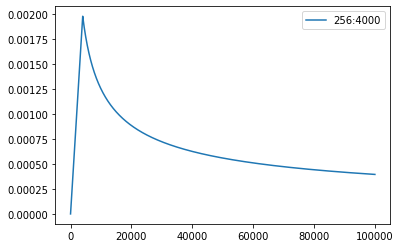

In [ ]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [ ]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [ ]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [ ]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights

In [ ]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [ ]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [ ]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-04-23 14:13:18 | INFO | hw5.seq2seq | task: TranslationTask
2022-04-23 14:13:18 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-04-23 14:13:18 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-04-23 14:13:18 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-04-23 14:13:18 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-04-23 14:13:18 | INFO | hw5.seq2seq | num. model params: 11,469,824 (num. trained: 11,469,824)
2022-04-23 14:13:18 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [ ]:
raise


RuntimeError: No active exception to reraise

In [ ]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-04-23 01:54:45 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2022-04-23 01:54:45 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/transformer_Reverse/checkpoint_last.pt!


train epoch 1:   0%|          | 0/800 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f69bc06f9d0>
Traceback (most recent call last):
  File "/home/siensien/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/siensien/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f69bc06f9d0>
Traceback (most recent call last):
  File "/home/siensien/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/siensien/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers

2022-04-23 01:56:50 | INFO | hw5.seq2seq | training loss: 6.2415
2022-04-23 01:56:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 01:57:14 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 01:57:14 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 01:57:14 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 01:57:14 | INFO | hw5.seq2seq | example source: 它是個美麗的國家 , 位在西非 。
2022-04-23 01:57:14 | INFO | hw5.seq2seq | example hypothesis: it's a lot of the world .
2022-04-23 01:57:14 | INFO | hw5.seq2seq | example reference: it is a beautiful country located in west africa .
2022-04-23 01:57:14 | INFO | hw5.seq2seq | validation loss:	4.9392
2022-04-23 01:57:14 | INFO | hw5.seq2seq | BLEU = 0.80 21.7/2.2/0.3/0.0 (BP = 0.882 ratio = 0.889 hyp_len = 68478 ref_len = 77050)
2022-04-23 01:57:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_Reverse/checkpoint1.pt
2022-04-2

train epoch 2:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 01:59:20 | INFO | hw5.seq2seq | training loss: 4.6187
2022-04-23 01:59:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 01:59:43 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 01:59:43 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 01:59:43 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 01:59:43 | INFO | hw5.seq2seq | example source: 他懂得策略 。
2022-04-23 01:59:43 | INFO | hw5.seq2seq | example hypothesis: he knew that he's going to be able to know .
2022-04-23 01:59:43 | INFO | hw5.seq2seq | example reference: arthur samuel knew strategy .
2022-04-23 01:59:43 | INFO | hw5.seq2seq | validation loss:	4.1011
2022-04-23 01:59:43 | INFO | hw5.seq2seq | BLEU = 5.48 36.3/10.2/3.6/1.3 (BP = 0.851 ratio = 0.862 hyp_len = 66379 ref_len = 77050)
2022-04-23 01:59:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_Reverse/checkpoint2.pt
2022-04-23 01:59:44 

train epoch 3:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:01:48 | INFO | hw5.seq2seq | training loss: 4.0441
2022-04-23 02:01:48 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:02:12 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:02:12 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:02:12 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:02:12 | INFO | hw5.seq2seq | example source: 你可以成為傑出的一代 。 」
2022-04-23 02:02:12 | INFO | hw5.seq2seq | example hypothesis: you can become a generation . "
2022-04-23 02:02:12 | INFO | hw5.seq2seq | example reference: you can be that great generation . "
2022-04-23 02:02:12 | INFO | hw5.seq2seq | validation loss:	3.6353
2022-04-23 02:02:12 | INFO | hw5.seq2seq | BLEU = 8.26 43.5/14.8/6.1/2.6 (BP = 0.824 ratio = 0.838 hyp_len = 64580 ref_len = 77050)
2022-04-23 02:02:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_Reverse/checkpoint3.pt
2022-04-23 02:02:13

train epoch 4:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:04:15 | INFO | hw5.seq2seq | training loss: 3.7209
2022-04-23 02:04:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:04:46 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:04:46 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:04:46 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:04:46 | INFO | hw5.seq2seq | example source: 它驅使人們離開大腦聰明的那部份那個潛意識的黑暗深井本能和經驗所在的地方以及所有其他創意的元素還有良好判斷力所在之處它迫使我們去到單薄又呆板有意識的邏輯 。
2022-04-23 02:04:46 | INFO | hw5.seq2seq | example hypothesis: it drives people to leave the smart darkness of the brain , and the darkness of consciousness of consciousness and experiences and all other creative elements and all other creativity , and it forces us to think and logics .
2022-04-23 02:04:46 | INFO | hw5.seq2seq | example reference: it drives people from the smart part of the brain that dark , deep well of the subconscious , where instincts and experience , and a

train epoch 5:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:06:51 | INFO | hw5.seq2seq | training loss: 3.5641
2022-04-23 02:06:51 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:07:14 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:07:14 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:07:14 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:07:15 | INFO | hw5.seq2seq | example source: 「 事情並無好壞/是我們的思維使之如此 」
2022-04-23 02:07:15 | INFO | hw5.seq2seq | example hypothesis: " it's a bad thing , " it's our thoughts . "
2022-04-23 02:07:15 | INFO | hw5.seq2seq | example reference: that seems like a onequestion iq test .
2022-04-23 02:07:15 | INFO | hw5.seq2seq | validation loss:	3.2975
2022-04-23 02:07:15 | INFO | hw5.seq2seq | BLEU = 11.99 48.1/19.0/8.8/4.3 (BP = 0.880 ratio = 0.887 hyp_len = 68341 ref_len = 77050)
2022-04-23 02:07:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_Reverse/checkpoint

train epoch 6:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:09:19 | INFO | hw5.seq2seq | training loss: 3.4479
2022-04-23 02:09:19 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:09:43 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:09:43 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:09:43 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:09:43 | INFO | hw5.seq2seq | example source: 謝謝 。
2022-04-23 02:09:43 | INFO | hw5.seq2seq | example hypothesis: thank you very much .
2022-04-23 02:09:43 | INFO | hw5.seq2seq | example reference: thank you .
2022-04-23 02:09:43 | INFO | hw5.seq2seq | validation loss:	3.1858
2022-04-23 02:09:43 | INFO | hw5.seq2seq | BLEU = 13.06 50.9/21.2/10.2/5.1 (BP = 0.847 ratio = 0.858 hyp_len = 66078 ref_len = 77050)
2022-04-23 02:09:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_Reverse/checkpoint6.pt
2022-04-23 02:09:44 | INFO | hw5.seq2seq | end of epoch 6


train epoch 7:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:11:50 | INFO | hw5.seq2seq | training loss: 3.3426
2022-04-23 02:11:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:12:19 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:12:19 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:12:19 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:12:19 | INFO | hw5.seq2seq | example source: 不 。
2022-04-23 02:12:19 | INFO | hw5.seq2seq | example hypothesis: no .
2022-04-23 02:12:19 | INFO | hw5.seq2seq | example reference: no .
2022-04-23 02:12:19 | INFO | hw5.seq2seq | validation loss:	3.1306
2022-04-23 02:12:19 | INFO | hw5.seq2seq | BLEU = 13.20 53.4/22.7/11.2/5.8 (BP = 0.788 ratio = 0.808 hyp_len = 62249 ref_len = 77050)
2022-04-23 02:12:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_Reverse/checkpoint7.pt
2022-04-23 02:12:20 | INFO | hw5.seq2seq | end of epoch 7


train epoch 8:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:14:25 | INFO | hw5.seq2seq | training loss: 3.2693
2022-04-23 02:14:25 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:14:48 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:14:48 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:14:48 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:14:48 | INFO | hw5.seq2seq | example source: 自行車是只在美國南部一些城市正在進行的革命
2022-04-23 02:14:48 | INFO | hw5.seq2seq | example hypothesis: bike cars are only in southern revolution .
2022-04-23 02:14:48 | INFO | hw5.seq2seq | example reference: bicycles and bicycling are the current revolution underway in only some american cities .
2022-04-23 02:14:48 | INFO | hw5.seq2seq | validation loss:	3.0604
2022-04-23 02:14:48 | INFO | hw5.seq2seq | BLEU = 14.46 53.9/23.6/11.9/6.2 (BP = 0.826 ratio = 0.839 hyp_len = 64675 ref_len = 77050)
2022-04-23 02:14:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siens

train epoch 9:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:16:51 | INFO | hw5.seq2seq | training loss: 3.2128
2022-04-23 02:16:51 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:17:18 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:17:18 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:17:18 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:17:18 | INFO | hw5.seq2seq | example source: jc:我覺得很有意思 。
2022-04-23 02:17:18 | INFO | hw5.seq2seq | example hypothesis: jc: i think it's interesting .
2022-04-23 02:17:18 | INFO | hw5.seq2seq | example reference: jc: it makes perfect sense to me .
2022-04-23 02:17:18 | INFO | hw5.seq2seq | validation loss:	3.0261
2022-04-23 02:17:18 | INFO | hw5.seq2seq | BLEU = 14.41 54.8/24.2/12.2/6.3 (BP = 0.805 ratio = 0.822 hyp_len = 63329 ref_len = 77050)
2022-04-23 02:17:19 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_Reverse/checkpoint9.pt
2022-04-23 02:17:19 | 

train epoch 10:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:19:24 | INFO | hw5.seq2seq | training loss: 3.1698
2022-04-23 02:19:24 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:19:48 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:19:48 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:19:48 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:19:48 | INFO | hw5.seq2seq | example source: 這就是問題所在彼得‧德森指出了這點他用的例子是某種鴨嘴恐龍當時被稱為亞冠龍
2022-04-23 02:19:48 | INFO | hw5.seq2seq | example hypothesis: and that's the problem in peter dson , which is the case that he used a ducky mouth dinosaur , which was called a champion .
2022-04-23 02:19:48 | INFO | hw5.seq2seq | example reference: so this was a problem , and peter dodson pointed this out using some duckbilled dinosaurs then called hypacrosaurus .
2022-04-23 02:19:48 | INFO | hw5.seq2seq | validation loss:	3.0021
2022-04-23 02:19:48 | INFO | hw5.seq2seq | BLEU = 14.64 54.1/23.9/12.2/6.4 (BP = 0.823 

train epoch 11:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:21:53 | INFO | hw5.seq2seq | training loss: 3.1374
2022-04-23 02:21:53 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:22:17 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:22:17 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:22:17 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:22:17 | INFO | hw5.seq2seq | example source: 她說: 「 放下你的身段 , 錢是『綠色』的 。 」
2022-04-23 02:22:17 | INFO | hw5.seq2seq | example hypothesis: she said , " let's put your identity , it's green . "
2022-04-23 02:22:17 | INFO | hw5.seq2seq | example reference: she said , " get off your throne . money is green . "
2022-04-23 02:22:17 | INFO | hw5.seq2seq | validation loss:	2.9654
2022-04-23 02:22:17 | INFO | hw5.seq2seq | BLEU = 15.87 52.4/23.2/11.9/6.3 (BP = 0.914 ratio = 0.918 hyp_len = 70710 ref_len = 77050)
2022-04-23 02:22:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/t

train epoch 12:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:24:20 | INFO | hw5.seq2seq | training loss: 3.1081
2022-04-23 02:24:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:24:44 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:24:44 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:24:44 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:24:44 | INFO | hw5.seq2seq | example source: 成為領導者是我的抱負 , 我想問 , 在沒有影響力時 , 你要如何領導 ?
2022-04-23 02:24:44 | INFO | hw5.seq2seq | example hypothesis: as a leader , i want to ask , how do you lead when you don't influence ?
2022-04-23 02:24:44 | INFO | hw5.seq2seq | example reference: i'm an aspiring leader , and i have a question about how you lead when you have no influence .
2022-04-23 02:24:44 | INFO | hw5.seq2seq | validation loss:	2.9476
2022-04-23 02:24:44 | INFO | hw5.seq2seq | BLEU = 16.29 52.3/23.4/12.0/6.3 (BP = 0.932 ratio = 0.935 hyp_len = 72014 ref_len = 77050)
2022-04-23 02:24:44 | INFO |

train epoch 13:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:26:57 | INFO | hw5.seq2seq | training loss: 3.0843
2022-04-23 02:26:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:27:20 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:27:20 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:27:20 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:27:20 | INFO | hw5.seq2seq | example source: 這樣 , 英國國教的牧師就可以教訓無神論者 , 說他們的言論有多麼冒犯人 ;
2022-04-23 02:27:20 | INFO | hw5.seq2seq | example hypothesis: so , the british prisoner can teach atheists , to say how fake their speechs are .
2022-04-23 02:27:20 | INFO | hw5.seq2seq | example reference: so anglican ministers could lecture atheists on the offensiveness of their discourse .
2022-04-23 02:27:20 | INFO | hw5.seq2seq | validation loss:	2.9422
2022-04-23 02:27:20 | INFO | hw5.seq2seq | BLEU = 15.79 55.5/25.1/13.0/6.9 (BP = 0.838 ratio = 0.849 hyp_len = 65450 ref_len = 77050)
2022-04-23 02:27:21 | INF

train epoch 14:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:29:24 | INFO | hw5.seq2seq | training loss: 3.0620
2022-04-23 02:29:24 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:29:55 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:29:55 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:29:55 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:29:55 | INFO | hw5.seq2seq | example source: 所以 , 我們說 , 好 , 咱們來研究看看這是如何發生的 , 先看科學 。
2022-04-23 02:29:55 | INFO | hw5.seq2seq | example hypothesis: so we said , okay , let's look at how this is happening , look at science .
2022-04-23 02:29:55 | INFO | hw5.seq2seq | example reference: so we said , ok , let's figure out how does this really happen , first in science .
2022-04-23 02:29:55 | INFO | hw5.seq2seq | validation loss:	2.9226
2022-04-23 02:29:55 | INFO | hw5.seq2seq | BLEU = 15.95 55.0/25.0/12.9/6.9 (BP = 0.853 ratio = 0.863 hyp_len = 66479 ref_len = 77050)
2022-04-23 02:29:55 | INFO | hw5.se

train epoch 15:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:32:02 | INFO | hw5.seq2seq | training loss: 3.0445
2022-04-23 02:32:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:32:33 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:32:33 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:32:33 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:32:33 | INFO | hw5.seq2seq | example source: 然而此時此刻我們滅絕這些病症的能力也已經達到了超乎想像的高峰
2022-04-23 02:32:33 | INFO | hw5.seq2seq | example hypothesis: and yet , at this point , we're extincting the ability to extinct these symptoms , and we've reached the peak of superimagination .
2022-04-23 02:32:33 | INFO | hw5.seq2seq | example reference: and yet we also live at the moment when our ability to eliminate those conditions has reached a height we never imagined before .
2022-04-23 02:32:33 | INFO | hw5.seq2seq | validation loss:	2.9010
2022-04-23 02:32:33 | INFO | hw5.seq2seq | BLEU = 16.73 53.0/24.0/12.4/6.6 

train epoch 16:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:34:46 | INFO | hw5.seq2seq | training loss: 3.0309
2022-04-23 02:34:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:35:11 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:35:11 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:35:11 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:35:11 | INFO | hw5.seq2seq | example source: 是因為勤奮的工作 。 是因為我們發現了有關恐怖活動的情報並且以不同的方式禁止 , 通過執法 , 通過和其他國家的合作 , 而且有時候通過軍事活動 。
2022-04-23 02:35:11 | INFO | hw5.seq2seq | example hypothesis: it's because of the work of commute is because we discovered the report of terror activity and banned in different ways , through enforcement , collaboration with other countries , and sometimes through military activities .
2022-04-23 02:35:11 | INFO | hw5.seq2seq | example reference: that's hard work . that's us finding intelligence on terrorist activities and interdicting them through one way or another , through la

train epoch 17:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:37:17 | INFO | hw5.seq2seq | training loss: 3.0147
2022-04-23 02:37:17 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:37:41 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:37:41 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:37:41 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:37:41 | INFO | hw5.seq2seq | example source: 這是過去40年來女性不斷倡導的結果
2022-04-23 02:37:41 | INFO | hw5.seq2seq | example hypothesis: this is the result that women have been advocating for the last 40 years .
2022-04-23 02:37:41 | INFO | hw5.seq2seq | example reference: and that is the 40 years that women have advocated .
2022-04-23 02:37:41 | INFO | hw5.seq2seq | validation loss:	2.8834
2022-04-23 02:37:41 | INFO | hw5.seq2seq | BLEU = 16.07 55.6/25.5/13.4/7.1 (BP = 0.837 ratio = 0.849 hyp_len = 65432 ref_len = 77050)
2022-04-23 02:37:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/ch

train epoch 18:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:39:46 | INFO | hw5.seq2seq | training loss: 3.0028
2022-04-23 02:39:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:40:10 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:40:10 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:40:10 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:40:10 | INFO | hw5.seq2seq | example source: 所有人都安全了 。
2022-04-23 02:40:10 | INFO | hw5.seq2seq | example hypothesis: everyone is safe .
2022-04-23 02:40:10 | INFO | hw5.seq2seq | example reference: and no one got killed .
2022-04-23 02:40:10 | INFO | hw5.seq2seq | validation loss:	2.8736
2022-04-23 02:40:10 | INFO | hw5.seq2seq | BLEU = 16.70 55.5/25.7/13.6/7.4 (BP = 0.857 ratio = 0.866 hyp_len = 66741 ref_len = 77050)
2022-04-23 02:40:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_Reverse/checkpoint18.pt
2022-04-23 02:40:10 | INFO | hw5.seq2seq | end 

train epoch 19:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:42:16 | INFO | hw5.seq2seq | training loss: 2.9898
2022-04-23 02:42:16 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:42:40 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:42:40 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:42:40 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:42:40 | INFO | hw5.seq2seq | example source: 其他人則是靠著很不適合的獨木舟 , 孤注一擲試圖前往西班牙 。
2022-04-23 02:42:40 | INFO | hw5.seq2seq | example hypothesis: others are dependent on a very uncomfortable canoe , and they're trying to flip to spain .
2022-04-23 02:42:40 | INFO | hw5.seq2seq | example reference: others end up on inadequate wooden canoes in desperate attempts to reach spain .
2022-04-23 02:42:40 | INFO | hw5.seq2seq | validation loss:	2.8691
2022-04-23 02:42:40 | INFO | hw5.seq2seq | BLEU = 16.82 55.3/25.6/13.5/7.3 (BP = 0.868 ratio = 0.876 hyp_len = 67520 ref_len = 77050)
2022-04-23 02:42:40 | INFO | h

train epoch 20:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:44:47 | INFO | hw5.seq2seq | training loss: 2.9798
2022-04-23 02:44:47 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:45:11 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:45:11 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:45:11 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:45:11 | INFO | hw5.seq2seq | example source: 對了 , 如果你還沒有注意到 , 我是黑人 , 謝謝 。 如果你像我一樣 , 生長在種族隔離的城市 , 例如芝加哥 , 你自然而然就相信膚色和種族永遠是分不開的 。
2022-04-23 02:45:11 | INFO | hw5.seq2seq | example hypothesis: by the way , if you haven't noticed , i'm black , thank you . if you're like me , growing in a city of racial segregation , like chicago , you naturally believe in color and race .
2022-04-23 02:45:11 | INFO | hw5.seq2seq | example reference: now , if you haven't noticed , i am black , thank you and when you grow up in a segregated city as i have , like chicago , you're conditioned to believe that color and rac

train epoch 21:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:47:15 | INFO | hw5.seq2seq | training loss: 2.9691
2022-04-23 02:47:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:47:39 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:47:39 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:47:39 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:47:39 | INFO | hw5.seq2seq | example source: 如果你是使用蘋果的keynote , 就有更好的版本能用
2022-04-23 02:47:39 | INFO | hw5.seq2seq | example hypothesis: if you're using the keynote , there's a better version of instincts .
2022-04-23 02:47:39 | INFO | hw5.seq2seq | example reference: if you use apple's keynote , it's got an even better version .
2022-04-23 02:47:39 | INFO | hw5.seq2seq | validation loss:	2.8457
2022-04-23 02:47:39 | INFO | hw5.seq2seq | BLEU = 17.49 54.6/25.5/13.6/7.5 (BP = 0.900 ratio = 0.905 hyp_len = 69723 ref_len = 77050)
2022-04-23 02:47:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /home

train epoch 22:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:49:46 | INFO | hw5.seq2seq | training loss: 2.9604
2022-04-23 02:49:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:50:10 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:50:10 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:50:10 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:50:10 | INFO | hw5.seq2seq | example source: 這是1970年中國的收入分配
2022-04-23 02:50:10 | INFO | hw5.seq2seq | example hypothesis: this is the income distribution in china in 1970 .
2022-04-23 02:50:10 | INFO | hw5.seq2seq | example reference: this is the income distribution of china , 1970 .
2022-04-23 02:50:10 | INFO | hw5.seq2seq | validation loss:	2.8476
2022-04-23 02:50:10 | INFO | hw5.seq2seq | BLEU = 17.07 55.9/26.1/13.9/7.7 (BP = 0.860 ratio = 0.869 hyp_len = 66924 ref_len = 77050)
2022-04-23 02:50:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_Reverse/

train epoch 23:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:52:14 | INFO | hw5.seq2seq | training loss: 2.9523
2022-04-23 02:52:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:52:39 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:52:39 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:52:39 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:52:39 | INFO | hw5.seq2seq | example source: 他是律師兼作家 , 笑的時候眼睛閃閃發光 , 我親他的時候 , 他緊緊閉上雙眼 , 在那晚的某一刻 , 我們的第零次約會
2022-04-23 02:52:39 | INFO | hw5.seq2seq | example hypothesis: he's a lawyer and author , and when the eyes laughed , the light flashed , and when i related to him , he closed his eyes , and at some point at that night , our zero dates .
2022-04-23 02:52:39 | INFO | hw5.seq2seq | example reference: he was a lawyer and a writer , and his eyes twinkled when he laughed and they squeezed tight when i kissed him and at some point in the evening , our zero date became a first date .
2022-04-23 02:52:

train epoch 24:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:54:42 | INFO | hw5.seq2seq | training loss: 2.9437
2022-04-23 02:54:42 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:55:06 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:55:06 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:55:06 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:55:06 | INFO | hw5.seq2seq | example source: 用特斯拉 , 因你要有永續能源 , 所以造出這麽勁爆的車子來實現你的目標 。
2022-04-23 02:55:06 | INFO | hw5.seq2seq | example hypothesis: using tesla , because you have sustainable energy , so you create this amazing explosion of cars to realize your goal .
2022-04-23 02:55:06 | INFO | hw5.seq2seq | example reference: with tesla , you want to have sustainable energy , so you made these super sexy , exciting cars to do it .
2022-04-23 02:55:06 | INFO | hw5.seq2seq | validation loss:	2.8323
2022-04-23 02:55:06 | INFO | hw5.seq2seq | BLEU = 17.59 54.6/25.4/13.6/7.4 (BP = 0.912 ratio = 0.916 h

train epoch 25:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:57:15 | INFO | hw5.seq2seq | training loss: 2.9376
2022-04-23 02:57:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 02:57:39 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 02:57:39 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 02:57:39 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 02:57:39 | INFO | hw5.seq2seq | example source: 你要做的 , 就是把你的問題和以前別人所遇到的問題做比對 , 再利用他們已經想出的辦法來解決 。
2022-04-23 02:57:39 | INFO | hw5.seq2seq | example hypothesis: what you're going to do is compare your questions and the problems that other people have met before , and use them to solve the solutions that they've figured out .
2022-04-23 02:57:39 | INFO | hw5.seq2seq | example reference: because what you can do is take your problem , and turn it into a problem that someone else has solved , and use their solutions .
2022-04-23 02:57:39 | INFO | hw5.seq2seq | validation loss:	2.8216
2022-04-23 02:57:39 | 

train epoch 26:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 02:59:42 | INFO | hw5.seq2seq | training loss: 2.9321
2022-04-23 02:59:42 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 03:00:06 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 03:00:06 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 03:00:06 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 03:00:06 | INFO | hw5.seq2seq | example source: 在同樣的狀況下他們該怎麼做 ?
2022-04-23 03:00:06 | INFO | hw5.seq2seq | example hypothesis: what do they do in the same situation ?
2022-04-23 03:00:06 | INFO | hw5.seq2seq | example reference: what would they do under the same conditions ?
2022-04-23 03:00:06 | INFO | hw5.seq2seq | validation loss:	2.8241
2022-04-23 03:00:06 | INFO | hw5.seq2seq | BLEU = 17.45 55.7/26.1/13.9/7.6 (BP = 0.880 ratio = 0.887 hyp_len = 68326 ref_len = 77050)
2022-04-23 03:00:07 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_Reverse/checkpoint26.

train epoch 27:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 03:02:15 | INFO | hw5.seq2seq | training loss: 2.9244
2022-04-23 03:02:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 03:02:39 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 03:02:39 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 03:02:39 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 03:02:39 | INFO | hw5.seq2seq | example source: 這帶給我想到第三個假設而這也許是問題最大的假設: " 永遠不要對選擇說不 " 。
2022-04-23 03:02:39 | INFO | hw5.seq2seq | example hypothesis: it brought me a third assumption , and perhaps the biggest assumption of the problem: " never speak to choice . "
2022-04-23 03:02:39 | INFO | hw5.seq2seq | example reference: this brings me to the third , and perhaps most problematic , assumption: " you must never say no to choice . "
2022-04-23 03:02:39 | INFO | hw5.seq2seq | validation loss:	2.8168
2022-04-23 03:02:39 | INFO | hw5.seq2seq | BLEU = 17.56 56.0/26.4/14.1/7.7 (BP = 0.876 ratio = 0.883 h

train epoch 28:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 03:04:46 | INFO | hw5.seq2seq | training loss: 2.9184
2022-04-23 03:04:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 03:05:10 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 03:05:10 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 03:05:10 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 03:05:10 | INFO | hw5.seq2seq | example source: 沒有錢乘車 , 他們通常都會坐在卡車頂上 , 在這裡則是坐在橫越南蘇丹的火車頂上 。
2022-04-23 03:05:10 | INFO | hw5.seq2seq | example hypothesis: without money multiplied cars , they're usually sitting on top of trucks , on top of the trains across south sudan .
2022-04-23 03:05:10 | INFO | hw5.seq2seq | example reference: with no money for rides , they often made the mzungu ride on the roof of the trucks , or in this case , on the top of the train going across south sudan .
2022-04-23 03:05:10 | INFO | hw5.seq2seq | validation loss:	2.8057
2022-04-23 03:05:10 | INFO | hw5.seq2seq | BLEU = 17.

train epoch 29:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 03:07:24 | INFO | hw5.seq2seq | training loss: 2.9130
2022-04-23 03:07:24 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 03:07:51 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 03:07:51 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 03:07:51 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 03:07:51 | INFO | hw5.seq2seq | example source: 我可以把鏡頭向右旋轉一點 , 你就會失焦 , 而背景的人會凸顯出來 。
2022-04-23 03:07:51 | INFO | hw5.seq2seq | example hypothesis: i can rotate the lens to the right , and you'll lose your attention , and the background will show up .
2022-04-23 03:07:51 | INFO | hw5.seq2seq | example reference: i could move the lens a little to the right , and you would go back and the folks in the background would come out .
2022-04-23 03:07:51 | INFO | hw5.seq2seq | validation loss:	2.8078
2022-04-23 03:07:51 | INFO | hw5.seq2seq | BLEU = 17.45 56.4/26.8/14.4/7.9 (BP = 0.857 ratio = 0.866 hyp_len = 

train epoch 30:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-23 03:09:55 | INFO | hw5.seq2seq | training loss: 2.9066
2022-04-23 03:09:55 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 03:10:19 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 03:10:19 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 03:10:19 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 03:10:19 | INFO | hw5.seq2seq | example source: 身為白人女性 , 我們得要做更多 , 因為種族主義、性別主義 , 和恐同性戀症 , 是影響我們所有人的議題 。
2022-04-23 03:10:19 | INFO | hw5.seq2seq | example hypothesis: as a white woman , we need to do more , because racism , genderism and homosexuality is affecting all of us .
2022-04-23 03:10:19 | INFO | hw5.seq2seq | example reference: and as white women , we have to do more , because racism and sexism and homophobia , these are issues that affect all of us .
2022-04-23 03:10:19 | INFO | hw5.seq2seq | validation loss:	2.8017
2022-04-23 03:10:19 | INFO | hw5.seq2seq | BLEU = 17.94 55.0/26.0/13.9/7.7 (

# Submission

In [ ]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir 
!python3 ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/transformer_Reverse'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/transformer_Reverse/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/transformer_Reverse/checkpoint30.pt', './checkpoints/transformer_Reverse/checkpoint29.pt', './checkpoints/transformer_Reverse/checkpoint28.pt', './checkpoints/transformer_Reverse/checkpoint27.pt', './checkpoints/transformer_Reverse/checkpoint26.pt']
Finished writing averaged checkpoint to ./checkpoints/transformer_Reverse/avg_last_5_checkpoint.pt


## Confirm model weights used to generate submission

In [ ]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2022-04-23 14:25:17 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer_Reverse/avg_last_5_checkpoint.pt: step=unknown loss=2.801738739013672 bleu=17.94360274533797
2022-04-23 14:25:17 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s]

2022-04-23 14:25:41 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-23 14:25:41 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-23 14:25:41 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-23 14:25:41 | INFO | hw5.seq2seq | example source: 它是個美麗的國家 , 位在西非 。
2022-04-23 14:25:41 | INFO | hw5.seq2seq | example hypothesis: it's a beautiful country in west africa .
2022-04-23 14:25:41 | INFO | hw5.seq2seq | example reference: it is a beautiful country located in west africa .
2022-04-23 14:25:41 | INFO | hw5.seq2seq | validation loss:	2.7957
2022-04-23 14:25:41 | INFO | hw5.seq2seq | BLEU = 17.88 56.2/26.7/14.4/7.9 (BP = 0.880 ratio = 0.886 hyp_len = 68290 ref_len = 77050)


## Generate Prediction

In [ ]:
def generate_prediction(model, task, split="test", outfile="./prediction_transformer_reverse.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [ ]:
generate_prediction(model, task)

2022-04-23 03:10:55 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/test.zh-en.zh
2022-04-23 03:10:55 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/test.zh-en.en
2022-04-23 03:10:55 | INFO | fairseq.tasks.translation | /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data test zh-en 4000 examples


prediction:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
raise

RuntimeError: No active exception to reraise

# Back-translation

## Train a backward translation model

1. Switch the source_lang and target_lang in **config** 
2. Change the savedir in **config** (eg. "./checkpoints/transformer-back")
3. Train model

## Generate synthetic data with backward model 

### Download monolingual data

In [ ]:
mono_dataset_name = 'mono'
mono_prefix = Path(data_dir).absolute() / dataset_name / mono_dataset_name
print(mono_prefix)

/home/siensien/hw5/hw5_data/mono


In [ ]:
'''
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted_zh_corpus.deduped.gz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vMNnDShR!4eHDxzlpzIpdpeQTD-htatU_C7QwcBTwGDaSeBqH534",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}
'''

### TODO: clean corpus

1. remove sentences that are too long or too short
2. unify punctuation

hint: you can use clean_s() defined above to do this

In [ ]:
# copy from clean_corpus function, just change the mono file path
def clean_mono_corpus(mono_prefix, l1, l2, max_len=1000, min_len=1):
    if Path(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1}').exists() and Path(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l2}').exists():
        print(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{mono_prefix}/ted_zh_corpus.deduped', 'r') as l1_in_f:
        with open(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1}', 'w') as l1_out_f:
            with open(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l2}', 'w') as l2_out_f:
                for s1 in l1_in_f:
                    s1 = s1.strip()
                    s1 = clean_s(s1, l1)
                    s1_len = len_s(s1, l1)
                    if min_len > 0: # remove short sentence
                        if s1_len < min_len:
                            continue
                    if max_len > 0: # remove long sentence
                        if s1_len > max_len:
                            continue
                    print(s1, file=l1_out_f)
                    print('.', file=l2_out_f)  # en is empty


In [ ]:
clean_mono_corpus(mono_prefix, 'zh','en')


In [ ]:
path_zh = Path(f'{mono_prefix}/ted_zh_corpus.deduped.clean.zh')
path_en = Path(f'{mono_prefix}/ted_zh_corpus.deduped.clean.en')
!head {path_zh} -n 5
!head {path_en} -n 5


在16世紀中葉意大利人被一種男歌手迷住了那種男歌手的音域廣闊 , 包含的音高先前是一般成年男性不可能達到的
但是 , 這天賦有一個很高的代價
要防止他們變聲這些歌手在青春期前被閹割來停止荷爾蒙的變化 , 以免他們的聲線變低沉
被稱為 「 閹伶 」 , 他們輕輕的、天使般的聲音在整個歐洲很有名直到這個殘酷的程序 , 在19世紀被禁止
雖然阻止聲帶的成長 , 可以產生一個非凡廣闊的音域但自然發展的聲音 , 已經具有極多的可能性
.
.
.
.
.


### TODO: Subword Units

Use the spm model of the backward model to tokenize the data into subword units

hint: spm model is located at DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

In [ ]:
# reference spm function
for lang in ['zh','en']:
    out_path = mono_prefix/f'mono.tok.{lang}'
    if out_path.exists():
        print(f"{out_path} exists. skipping spm_encode.")
    else:
        with open(mono_prefix/f'mono.tok.{lang}', 'w') as out_f:
            with open(mono_prefix/f'ted_zh_corpus.deduped.clean.{lang}', 'r') as in_f:
                for line in in_f:
                    line = line.strip()
                    tok = spm_model.encode(line, out_type=str)
                    print(' '.join(tok), file=out_f)


### Binarize

use fairseq to binarize data

In [ ]:
binpath = Path('/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/'+mono_dataset_name)

src_dict_file = '/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/dict.zh.txt'
tgt_dict_file = '/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/dict.en.txt'
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python3 -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2


2022-04-23 14:31:00 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/mono', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='zh', srcdict='/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/dict.zh.txt', suppress_crashes=False, target_lang='en', task='translation', tensorboard_logdir=None, testpref=N

### TODO: Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [ ]:
# Add binarized monolingual data to the original data directory, and name it with "split_name"
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/mono/train.zh-en.zh.bin /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/mono.zh-en.zh.bin
!cp /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/mono/train.zh-en.zh.idx /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/mono.zh-en.zh.idx
!cp /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/mono/train.zh-en.en.bin /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/mono.zh-en.en.bin
!cp /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/mono/train.zh-en.en.idx /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/mono.zh-en.en.idx

In [ ]:
# hint: do prediction on split='mono' to create prediction_file
# generate_prediction( ... ,split=... ,outfile=... )
generate_prediction(model, task, split="mono", outfile="/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/mono/mono_prediction.txt")


2022-04-23 14:33:43 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/mono.zh-en.zh
2022-04-23 14:33:43 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/mono.zh-en.en
2022-04-23 14:33:43 | INFO | fairseq.tasks.translation | /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data mono zh-en 781713 examples


prediction:   0%|          | 0/1715 [00:00<?, ?it/s]

In [ ]:
!head {'/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/mono/mono_prediction.txt'} -n 10


in the mid16th century , italians were fascinated by a man singer's voice singer , including the sound of adult male can't achieve .
but there's a high price for this day .
to prevent them from loud , these singers were castrated before they were puberty to stop hormones in order to sink their voices down .
they're called castratic , they're light , angel , and they're famously famous throughout europe until this brutal process was banned in the 19th century .
although the growth of the sound belt can produce an extraordinary speech area , natural development has a lot of possibilities .
growing up , our bodies experience two major changes to develop natural sound areas .
so how does our larynx work ? what makes the sound change ?
the sound of speaking is the result of many anatomy , but mainly depends on the size of age and vocal health and larynx .
the larynx is a complicated muscle and skeleton system supporting and moving belts or even more accurate calling " folding . "
in between

### TODO: Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [ ]:
# generate mono.tok.en by prediction file
with open(mono_prefix/f'mono.tok.en', 'w') as out_f:
    with open('/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/mono/mono_prediction.txt', 'r') as in_f:
        for line in in_f:
            line = line.strip()
            tok = spm_model.encode(line, out_type=str)
            print(' '.join(tok), file=out_f)

In [ ]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# hint: use fairseq to binarize these two files again
binpath = Path('/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/synthetic')
src_dict_file = '/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/dict.zh.txt'
tgt_dict_file = '/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/dict.en.txt'
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python3 -m fairseq_cli.preprocess\
         --source-lang 'zh'\
         --target-lang 'en'\
         --trainpref {monopref}\
         --destdir {binpath}\
         --srcdict {src_dict_file}\
         --tgtdict {tgt_dict_file}\
         --workers 2

2022-04-23 15:31:52 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/synthetic', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='zh', srcdict='/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/dict.zh.txt', suppress_crashes=False, target_lang='en', task='translation', tensorboard_logdir=None, testp

In [ ]:
# create a new dataset from all the files prepared above
!cp -r /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/ /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/data_with_mono/

!cp /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/synthetic/train.zh-en.zh.bin /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/data_with_mono/train1.en-zh.zh.bin
!cp /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/synthetic/train.zh-en.zh.idx /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/data_with_mono/train1.en-zh.zh.idx
!cp /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/synthetic/train.zh-en.en.bin /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/data_with_mono/train1.en-zh.en.bin
!cp /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/synthetic/train.zh-en.en.idx /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/data_with_mono/train1.en-zh.en.idx

cp: cannot copy a directory, '/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/', into itself, '/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/data_with_mono/'


Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/data-bin/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

# Configuration for Experiments

In [ ]:
config = Namespace(
    datadir = '/home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/data_with_mono',
    savedir = "./checkpoints/transformer_BT",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search : candidates
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging, default = false
    use_wandb=False,
)


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [ ]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-04-23 15:38:29 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2022-04-23 15:38:29 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [ ]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-04-23 15:38:34 | INFO | hw5.seq2seq | loading data for epoch 1
2022-04-23 15:38:34 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/data_with_mono/train.zh-en.en
2022-04-23 15:38:34 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/data_with_mono/train.zh-en.zh
2022-04-23 15:38:34 | INFO | fairseq.tasks.translation | /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/data_with_mono train en-zh 390041 examples
2022-04-23 15:38:34 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/data_with_mono/train1.en-zh.en
2022-04-23 15:38:34 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/data_with_mono/train1.en-zh.zh
2022-04-23 15:38:34 | INFO | fairseq.tasks.translation | /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/data_wi

## Dataset Iterator

In [ ]:
demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2022-04-23 15:38:44 | WARNING | fairseq.tasks.fairseq_task | 2,532 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[29, 135, 2444, 3058, 682, 731, 235, 1558, 3383, 559]


{'id': tensor([723]),
 'nsentences': 1,
 'ntokens': 18,
 'net_input': {'src_tokens': tensor([[   1,    1,    1,    1,    1,   18,   26,   82,    8,  480,   15,  651,
           1361,   38,    6,  176, 2696,   39,    5,  822,   92,  260,    7,    2]]),
  'src_lengths': tensor([19]),
  'prev_output_tokens': tensor([[   2,  140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,
            151, 2691,    9,  215, 1680,   10,    1,    1,    1,    1,    1,    1]])},
 'target': tensor([[ 140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,  151,
          2691,    9,  215, 1680,   10,    2,    1,    1,    1,    1,    1,    1]])}

## Architecture Related Configuration
reference implementation

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [ ]:
# you can adjust here to fine tune the performance
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=1024,
    encoder_layers=4,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=4,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)


# # HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
#     # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [ ]:
model = build_model(arch_args, task)
logger.info(model)

2022-04-23 15:40:16 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=256, bia

## Otimization

In [ ]:
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))

sequence_generator = task.build_generator([model], config)

# Main
## Training loop

In [ ]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [ ]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-04-23 15:40:26 | INFO | hw5.seq2seq | task: TranslationTask
2022-04-23 15:40:26 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-04-23 15:40:26 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-04-23 15:40:26 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-04-23 15:40:26 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-04-23 15:40:26 | INFO | hw5.seq2seq | num. model params: 11,469,824 (num. trained: 11,469,824)
2022-04-23 15:40:26 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [ ]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-04-23 15:40:38 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2022-04-23 15:40:38 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/transformer_BT/checkpoint_last.pt!


train epoch 1:   0%|          | 0/1852 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d0fe243a0>
Traceback (most recent call last):
  File "/home/siensien/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/siensien/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d0fe243a0>
Traceback (most recent call last):
  File "/home/siensien/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/siensien/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers

2022-04-23 15:45:28 | INFO | hw5.seq2seq | training loss: 5.9700
2022-04-23 15:45:28 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 15:45:50 | INFO | hw5.seq2seq | example source: we can push through that .
2022-04-23 15:45:50 | INFO | hw5.seq2seq | example hypothesis: 我們可以透過這樣推動 。
2022-04-23 15:45:50 | INFO | hw5.seq2seq | example reference: 我們可以衝破這些限制 。
2022-04-23 15:45:50 | INFO | hw5.seq2seq | validation loss:	4.8018
2022-04-23 15:45:50 | INFO | hw5.seq2seq | BLEU = 9.94 46.5/20.3/9.4/4.6 (BP = 0.698 ratio = 0.736 hyp_len = 82239 ref_len = 111811)
2022-04-23 15:45:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint1.pt
2022-04-23 15:45:50 | INFO | hw5.seq2seq | end of epoch 1


train epoch 2:   0%|          | 0/1852 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d0fe243a0>
Traceback (most recent call last):
  File "/home/siensien/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/siensien/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d0fe243a0>
Traceback (most recent call last):
  File "/home/siensien/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/siensien/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers

2022-04-23 15:50:38 | INFO | hw5.seq2seq | training loss: 4.2305
2022-04-23 15:50:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 15:51:01 | INFO | hw5.seq2seq | example source: thank you .
2022-04-23 15:51:01 | INFO | hw5.seq2seq | example hypothesis: 謝謝 。
2022-04-23 15:51:01 | INFO | hw5.seq2seq | example reference: 謝謝 。
2022-04-23 15:51:01 | INFO | hw5.seq2seq | validation loss:	4.2132
2022-04-23 15:51:01 | INFO | hw5.seq2seq | BLEU = 17.74 50.6/25.2/13.3/7.3 (BP = 0.945 ratio = 0.946 hyp_len = 105787 ref_len = 111811)
2022-04-23 15:51:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint2.pt
2022-04-23 15:51:02 | INFO | hw5.seq2seq | end of epoch 2


train epoch 3:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 15:55:48 | INFO | hw5.seq2seq | training loss: 3.8070
2022-04-23 15:55:48 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 15:56:09 | INFO | hw5.seq2seq | example source: those men would eventually be convicted of placing a van filled with 1 , 500 pounds of explosives into the sublevel parking lot of the world trade center's north tower , causing an explosion that killed six people and injured over 1 , 000 others .
2022-04-23 15:56:09 | INFO | hw5.seq2seq | example hypothesis: 那些男人最終會被指導 , 用一千五百磅的爆炸填滿了一千五百磅的爆炸 , 直到世界貿易中心的北角 , 造成了一場爆炸 , 殺死了超過一千個 。
2022-04-23 15:56:09 | INFO | hw5.seq2seq | example reference: 這群男人最終被指控將滿載1500磅重的炸彈的廂式貨車停在世界貿易中心北塔的地下停車場 , 爆炸造成6人死亡 , 同時致使超過1000人受傷 。
2022-04-23 15:56:09 | INFO | hw5.seq2seq | validation loss:	3.9647
2022-04-23 15:56:09 | INFO | hw5.seq2seq | BLEU = 20.19 53.8/28.0/15.3/8.8 (BP = 0.951 ratio = 0.952 hyp_len = 106499 ref_len = 111811)
2022-04-23 15:56:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint3.pt
2022-04-23 15:56:10 | INFO | hw5.seq2seq | end of epoch 3


train epoch 4:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 16:00:57 | INFO | hw5.seq2seq | training loss: 3.6059
2022-04-23 16:00:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 16:01:17 | INFO | hw5.seq2seq | example source: but this is really how i go about creating these photographs .
2022-04-23 16:01:17 | INFO | hw5.seq2seq | example hypothesis: 但這真的是我如何創造這些照片 。
2022-04-23 16:01:17 | INFO | hw5.seq2seq | example reference: 但是我真的是這樣做出這些相片的 。
2022-04-23 16:01:17 | INFO | hw5.seq2seq | validation loss:	3.8187
2022-04-23 16:01:17 | INFO | hw5.seq2seq | BLEU = 20.99 56.1/29.8/16.6/9.7 (BP = 0.921 ratio = 0.924 hyp_len = 103323 ref_len = 111811)
2022-04-23 16:01:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint4.pt
2022-04-23 16:01:18 | INFO | hw5.seq2seq | end of epoch 4


train epoch 5:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 16:06:06 | INFO | hw5.seq2seq | training loss: 3.5036
2022-04-23 16:06:06 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 16:06:26 | INFO | hw5.seq2seq | example source: so that is a fact .
2022-04-23 16:06:26 | INFO | hw5.seq2seq | example hypothesis: 所以 , 這是一個事實 。
2022-04-23 16:06:26 | INFO | hw5.seq2seq | example reference: 這就是事實
2022-04-23 16:06:26 | INFO | hw5.seq2seq | validation loss:	3.7428
2022-04-23 16:06:26 | INFO | hw5.seq2seq | BLEU = 21.57 56.1/30.2/17.0/10.1 (BP = 0.929 ratio = 0.931 hyp_len = 104099 ref_len = 111811)
2022-04-23 16:06:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint5.pt
2022-04-23 16:06:27 | INFO | hw5.seq2seq | end of epoch 5


train epoch 6:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 16:11:14 | INFO | hw5.seq2seq | training loss: 3.4413
2022-04-23 16:11:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 16:11:37 | INFO | hw5.seq2seq | example source: thank you so much everyone .
2022-04-23 16:11:37 | INFO | hw5.seq2seq | example hypothesis: 謝謝大家 。
2022-04-23 16:11:37 | INFO | hw5.seq2seq | example reference: 謝謝大家 !
2022-04-23 16:11:37 | INFO | hw5.seq2seq | validation loss:	3.7039
2022-04-23 16:11:37 | INFO | hw5.seq2seq | BLEU = 22.54 55.4/29.9/17.0/10.2 (BP = 0.975 ratio = 0.975 hyp_len = 109056 ref_len = 111811)
2022-04-23 16:11:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint6.pt
2022-04-23 16:11:38 | INFO | hw5.seq2seq | end of epoch 6


train epoch 7:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 16:16:26 | INFO | hw5.seq2seq | training loss: 3.3942
2022-04-23 16:16:26 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 16:16:47 | INFO | hw5.seq2seq | example source: these differences became a source of inspired artistic celebration .
2022-04-23 16:16:47 | INFO | hw5.seq2seq | example hypothesis: 這些差異變成了靈感藝術慶祝的來源 。
2022-04-23 16:16:47 | INFO | hw5.seq2seq | example reference: 這些差異變成了一個源頭 , 富有靈感之藝術讚頌的源頭 。
2022-04-23 16:16:47 | INFO | hw5.seq2seq | validation loss:	3.6587
2022-04-23 16:16:47 | INFO | hw5.seq2seq | BLEU = 22.33 57.8/31.7/18.1/10.9 (BP = 0.909 ratio = 0.913 hyp_len = 102103 ref_len = 111811)
2022-04-23 16:16:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint7.pt
2022-04-23 16:16:47 | INFO | hw5.seq2seq | end of epoch 7


train epoch 8:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 16:21:37 | INFO | hw5.seq2seq | training loss: 3.3596
2022-04-23 16:21:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 16:21:58 | INFO | hw5.seq2seq | example source: it's not .
2022-04-23 16:21:58 | INFO | hw5.seq2seq | example hypothesis: 不是
2022-04-23 16:21:58 | INFO | hw5.seq2seq | example reference: 不是
2022-04-23 16:21:58 | INFO | hw5.seq2seq | validation loss:	3.6330
2022-04-23 16:21:58 | INFO | hw5.seq2seq | BLEU = 22.81 57.5/31.6/18.1/10.9 (BP = 0.931 ratio = 0.933 hyp_len = 104315 ref_len = 111811)
2022-04-23 16:21:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint8.pt
2022-04-23 16:21:59 | INFO | hw5.seq2seq | end of epoch 8


train epoch 9:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 16:26:44 | INFO | hw5.seq2seq | training loss: 3.3327
2022-04-23 16:26:44 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 16:27:06 | INFO | hw5.seq2seq | example source: so think about when you have friends , families and coworkers in california , on the west coast or in other parts of the world .
2022-04-23 16:27:06 | INFO | hw5.seq2seq | example hypothesis: 所以 , 想想當你有朋友、家庭和同事在加州、西岸或世界上其他地區 。
2022-04-23 16:27:06 | INFO | hw5.seq2seq | example reference: 所以 , 想像當你嘗試聯繫在加州 , 在西海岸或者在世界的另一面
2022-04-23 16:27:06 | INFO | hw5.seq2seq | validation loss:	3.6375
2022-04-23 16:27:06 | INFO | hw5.seq2seq | BLEU = 23.08 57.1/31.5/18.0/10.8 (BP = 0.950 ratio = 0.951 hyp_len = 106344 ref_len = 111811)
2022-04-23 16:27:07 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint9.pt
2022-04-23 16:27:07 | INFO | hw5.seq2seq | end of epoch 9


train epoch 10:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 16:31:54 | INFO | hw5.seq2seq | training loss: 3.3106
2022-04-23 16:31:54 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 16:32:16 | INFO | hw5.seq2seq | example source: and i was asked to move out because one of my roommates had shared my status with her parents .
2022-04-23 16:32:16 | INFO | hw5.seq2seq | example hypothesis: 我被要求搬出去 , 因為我的一個室友和父母分享我的地位 。
2022-04-23 16:32:16 | INFO | hw5.seq2seq | example reference: 我會被要求搬出去 , 是因為其中一名室友和她的父母談了我的狀況 。
2022-04-23 16:32:16 | INFO | hw5.seq2seq | validation loss:	3.5997
2022-04-23 16:32:16 | INFO | hw5.seq2seq | BLEU = 23.78 55.9/30.8/17.7/10.7 (BP = 0.996 ratio = 0.996 hyp_len = 111371 ref_len = 111811)
2022-04-23 16:32:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint10.pt
2022-04-23 16:32:17 | INFO | hw5.seq2seq | end of epoch 10


train epoch 11:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 16:37:06 | INFO | hw5.seq2seq | training loss: 3.2934
2022-04-23 16:37:06 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 16:37:27 | INFO | hw5.seq2seq | example source: and i want to share with you a quick video from our facility that gives you a sense of how this looks at scale .
2022-04-23 16:37:27 | INFO | hw5.seq2seq | example hypothesis: 我想跟大家分享一段快速的影片 , 給你們看這個觀點如何看規模 。
2022-04-23 16:37:27 | INFO | hw5.seq2seq | example reference: 我想與你們快速分享一段關於我們設備的影片可以瞭解一下它的規模
2022-04-23 16:37:27 | INFO | hw5.seq2seq | validation loss:	3.5766
2022-04-23 16:37:27 | INFO | hw5.seq2seq | BLEU = 23.76 57.3/31.7/18.4/11.3 (BP = 0.958 ratio = 0.959 hyp_len = 107202 ref_len = 111811)
2022-04-23 16:37:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint11.pt
2022-04-23 16:37:27 | INFO | hw5.seq2seq | end of epoch 11


train epoch 12:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 16:42:13 | INFO | hw5.seq2seq | training loss: 3.2776
2022-04-23 16:42:13 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 16:42:34 | INFO | hw5.seq2seq | example source: it's a distinction perhaps we might make between two nobel laureates , richard feynman and john nash .
2022-04-23 16:42:34 | INFO | hw5.seq2seq | example hypothesis: 這是個區別 , 或許我們可能在兩個諾貝爾缺乏、理查.費因曼和約翰納許之間製造 。
2022-04-23 16:42:34 | INFO | hw5.seq2seq | example reference: 我們或許可以從兩位諾貝爾獎得主 , 理查費曼和約翰奈許之間看出這樣的差異 。
2022-04-23 16:42:34 | INFO | hw5.seq2seq | validation loss:	3.5834
2022-04-23 16:42:34 | INFO | hw5.seq2seq | BLEU = 23.70 56.8/31.3/18.1/11.0 (BP = 0.972 ratio = 0.972 hyp_len = 108681 ref_len = 111811)
2022-04-23 16:42:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint12.pt
2022-04-23 16:42:35 | INFO | hw5.seq2seq | end of epoch 12


train epoch 13:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 16:47:21 | INFO | hw5.seq2seq | training loss: 3.2644
2022-04-23 16:47:21 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 16:47:42 | INFO | hw5.seq2seq | example source: and therein lie the words of wisdom of a young girl whose brief life forever impacted mine .
2022-04-23 16:47:42 | INFO | hw5.seq2seq | example hypothesis: 在那裡 , 說謊了一位年輕女孩的智慧 , 她們的短暫生活永久受到影響 。
2022-04-23 16:47:42 | INFO | hw5.seq2seq | example reference: 她說的話對我有很大啟發 。 這一個年幼女孩短暫的一生永遠影響著我 。
2022-04-23 16:47:42 | INFO | hw5.seq2seq | validation loss:	3.5633
2022-04-23 16:47:42 | INFO | hw5.seq2seq | BLEU = 23.92 56.0/30.8/17.7/10.7 (BP = 1.000 ratio = 1.005 hyp_len = 112398 ref_len = 111811)
2022-04-23 16:47:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint13.pt
2022-04-23 16:47:43 | INFO | hw5.seq2seq | end of epoch 13


train epoch 14:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 16:52:31 | INFO | hw5.seq2seq | training loss: 3.2538
2022-04-23 16:52:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 16:52:52 | INFO | hw5.seq2seq | example source: and we've started making curtains , and not only is it beautiful , but people can see status that you care about your children .
2022-04-23 16:52:52 | INFO | hw5.seq2seq | example hypothesis: 我們開始製造簾子 , 不僅是它美麗 , 大家都能看到你在乎你的孩子的地位 。
2022-04-23 16:52:52 | INFO | hw5.seq2seq | example reference: 我們也開始生産窗簾不止因爲窗簾看起來漂亮 , 人們也可以看到你的地位看得出你很關心小孩
2022-04-23 16:52:52 | INFO | hw5.seq2seq | validation loss:	3.5734
2022-04-23 16:52:52 | INFO | hw5.seq2seq | BLEU = 23.69 57.3/31.8/18.3/11.1 (BP = 0.961 ratio = 0.962 hyp_len = 107544 ref_len = 111811)
2022-04-23 16:52:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint14.pt
2022-04-23 16:52:52 | INFO | hw5.seq2seq | end of epoch 14


train epoch 15:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 16:57:39 | INFO | hw5.seq2seq | training loss: 3.2458
2022-04-23 16:57:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 16:58:00 | INFO | hw5.seq2seq | example source: now , i'm not suggesting we want to raise our babies in our stomach , but i am suggesting it's possible we might want to manage gastric secretion in the gut .
2022-04-23 16:58:00 | INFO | hw5.seq2seq | example hypothesis: 現在 , 我並不是建議我們想要在我們的胃裡養育我們的嬰兒 , 但我建議這是有可能的 , 我們可能想在腸道上管理氣候分泌 。
2022-04-23 16:58:00 | INFO | hw5.seq2seq | example reference: 我並不是說要把嬰兒養在胃裡而是我們可能可以了解胃在內臟裡的分泌物
2022-04-23 16:58:00 | INFO | hw5.seq2seq | validation loss:	3.5546
2022-04-23 16:58:00 | INFO | hw5.seq2seq | BLEU = 24.05 57.2/31.8/18.4/11.2 (BP = 0.972 ratio = 0.972 hyp_len = 108676 ref_len = 111811)
2022-04-23 16:58:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint15.pt
2022-04-23 16:58:01 | INFO | hw5.seq2seq | end of epoch 15


train epoch 16:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 17:02:50 | INFO | hw5.seq2seq | training loss: 3.2358
2022-04-23 17:02:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 17:03:11 | INFO | hw5.seq2seq | example source: so we're hoping that's what they'll do .
2022-04-23 17:03:11 | INFO | hw5.seq2seq | example hypothesis: 所以我們希望這就是他們會做的事 。
2022-04-23 17:03:11 | INFO | hw5.seq2seq | example reference: 所以 , 我們希望它們能夠幫忙 。
2022-04-23 17:03:11 | INFO | hw5.seq2seq | validation loss:	3.5314
2022-04-23 17:03:11 | INFO | hw5.seq2seq | BLEU = 24.14 57.4/31.9/18.5/11.3 (BP = 0.969 ratio = 0.969 hyp_len = 108400 ref_len = 111811)
2022-04-23 17:03:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint16.pt
2022-04-23 17:03:12 | INFO | hw5.seq2seq | end of epoch 16


train epoch 17:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 17:08:00 | INFO | hw5.seq2seq | training loss: 3.2272
2022-04-23 17:08:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 17:08:21 | INFO | hw5.seq2seq | example source: i remember so vividly that day .
2022-04-23 17:08:21 | INFO | hw5.seq2seq | example hypothesis: 我記得那天如此的活躍 。
2022-04-23 17:08:21 | INFO | hw5.seq2seq | example reference: 我對那一天還記憶猶新 。
2022-04-23 17:08:21 | INFO | hw5.seq2seq | validation loss:	3.5271
2022-04-23 17:08:21 | INFO | hw5.seq2seq | BLEU = 23.90 57.8/32.4/18.8/11.5 (BP = 0.947 ratio = 0.949 hyp_len = 106073 ref_len = 111811)
2022-04-23 17:08:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint17.pt
2022-04-23 17:08:21 | INFO | hw5.seq2seq | end of epoch 17


train epoch 18:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 17:13:09 | INFO | hw5.seq2seq | training loss: 3.2199
2022-04-23 17:13:09 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 17:13:31 | INFO | hw5.seq2seq | example source: the next step is to make compliant toes , and try to add spines and claws and set it for dry adhesives .
2022-04-23 17:13:31 | INFO | hw5.seq2seq | example hypothesis: 下一步是要做出複雜的腳趾 , 試著加上脊椎和爪子 , 並設定乾燥黏著劑 。
2022-04-23 17:13:31 | INFO | hw5.seq2seq | example reference: 下一步是要製造順從聽話的腳趾頭 。 然後加上刺和爪子 , 再加上乾膠 。
2022-04-23 17:13:31 | INFO | hw5.seq2seq | validation loss:	3.5258
2022-04-23 17:13:31 | INFO | hw5.seq2seq | BLEU = 24.16 57.8/32.4/18.9/11.6 (BP = 0.954 ratio = 0.955 hyp_len = 106753 ref_len = 111811)
2022-04-23 17:13:31 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint18.pt
2022-04-23 17:13:32 | INFO | hw5.seq2seq | end of epoch 18


train epoch 19:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 17:18:19 | INFO | hw5.seq2seq | training loss: 3.2134
2022-04-23 17:18:19 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 17:18:41 | INFO | hw5.seq2seq | example source: and got the cord off of the baby's neck , and a healthy screaming , kicking baby arrived , just as the dad ran in from the parking lot , " hi , you have a son , i'm dr . darria .
2022-04-23 17:18:41 | INFO | hw5.seq2seq | example hypothesis: 然後把嬰兒的脖子拿出來 , 一個健康的尖叫 , 踢嬰兒抵達 , 就如同爸從停車場跑出來的那樣 , 「 嗨 , 你有個兒子 , 我是達瑞亞博士 。
2022-04-23 17:18:41 | INFO | hw5.seq2seq | example reference: 我把臍帶從嬰兒的脖子繞開 , 接著 , 一個健康哭鬧的嬰兒誕生了 。 同時 , 他的父親剛從停車場趕來 。 「 你好 , 是一個男孩 。 我是達里亞醫生 。
2022-04-23 17:18:41 | INFO | hw5.seq2seq | validation loss:	3.5219
2022-04-23 17:18:41 | INFO | hw5.seq2seq | BLEU = 24.29 56.9/31.8/18.5/11.2 (BP = 0.982 ratio = 0.983 hyp_len = 109857 ref_len = 111811)
2022-04-23 17:18:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint19.pt
2022-04-23 17:18:42 | INFO | hw5.seq2seq | end of epoch 19


train epoch 20:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 17:23:38 | INFO | hw5.seq2seq | training loss: 3.2073
2022-04-23 17:23:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 17:23:59 | INFO | hw5.seq2seq | example source: no , but the issue of city building in democracy is interesting because it creates chaos , right ?
2022-04-23 17:23:59 | INFO | hw5.seq2seq | example hypothesis: 不 , 但民主的城市建築的問題很有趣 , 因為它創造混亂 , 對吧 ?
2022-04-23 17:23:59 | INFO | hw5.seq2seq | example reference: 不 , 但民主的城市建設很有趣 , 因為會造成混亂 , 是嗎 ?
2022-04-23 17:23:59 | INFO | hw5.seq2seq | validation loss:	3.5061
2022-04-23 17:23:59 | INFO | hw5.seq2seq | BLEU = 24.34 57.7/32.3/18.8/11.6 (BP = 0.964 ratio = 0.964 hyp_len = 107837 ref_len = 111811)
2022-04-23 17:24:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint20.pt
2022-04-23 17:24:00 | INFO | hw5.seq2seq | end of epoch 20


train epoch 21:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 17:28:47 | INFO | hw5.seq2seq | training loss: 3.2026
2022-04-23 17:28:47 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 17:29:09 | INFO | hw5.seq2seq | example source: so i'm going to show you a demo of this .
2022-04-23 17:29:09 | INFO | hw5.seq2seq | example hypothesis: 所以我要讓你們看看這個的示範 。
2022-04-23 17:29:09 | INFO | hw5.seq2seq | example reference: 現在請各位看示範
2022-04-23 17:29:09 | INFO | hw5.seq2seq | validation loss:	3.5230
2022-04-23 17:29:09 | INFO | hw5.seq2seq | BLEU = 24.39 56.3/31.2/18.1/11.1 (BP = 1.000 ratio = 1.007 hyp_len = 112619 ref_len = 111811)
2022-04-23 17:29:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint21.pt
2022-04-23 17:29:10 | INFO | hw5.seq2seq | end of epoch 21


train epoch 22:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 17:33:58 | INFO | hw5.seq2seq | training loss: 3.1971
2022-04-23 17:33:58 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 17:34:19 | INFO | hw5.seq2seq | example source: you see , in every country where you hear about armed jihadis targeting civilians , there are also unarmed people defying those militants that you don't hear about , and those people need our support to succeed .
2022-04-23 17:34:19 | INFO | hw5.seq2seq | example hypothesis: 你看 , 在每個國家 , 你聽說武裝聖戰士標靶平民 , 同時也沒有人會打敗那些你不聽見的軍人 , 而那些人需要我們的支持才能成功 。
2022-04-23 17:34:19 | INFO | hw5.seq2seq | example reference: 你看 , 不管在哪個國家你都會聽到武裝聖戰者針對平民百姓 , 也有很多手無寸鐵的人民公然反抗那些激進分子 , 只是你沒聽過 , 那些人需要我們的支持才能成功 。
2022-04-23 17:34:19 | INFO | hw5.seq2seq | validation loss:	3.5066
2022-04-23 17:34:19 | INFO | hw5.seq2seq | BLEU = 24.47 56.4/31.4/18.2/11.1 (BP = 1.000 ratio = 1.007 hyp_len = 112641 ref_len = 111811)
2022-04-23 17:34:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint22.pt
2022-04-23 17:34:20 | INFO | hw5.seq2seq | end of epoch 22


train epoch 23:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 17:39:10 | INFO | hw5.seq2seq | training loss: 3.1917
2022-04-23 17:39:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 17:39:31 | INFO | hw5.seq2seq | example source: from gezi to tahrir to elsewhere , i've seen people put their lives and livelihoods on the line .
2022-04-23 17:39:31 | INFO | hw5.seq2seq | example hypothesis: 從gezi到tahrir到其他地方 , 我見過人們把他們的生活和生活在線上 。
2022-04-23 17:39:31 | INFO | hw5.seq2seq | example reference: 從格濟公園 , 到解放廣場 , 再到其它地方 , 我見過許多人用他們的生命和生計做賭注 。
2022-04-23 17:39:31 | INFO | hw5.seq2seq | validation loss:	3.5045
2022-04-23 17:39:31 | INFO | hw5.seq2seq | BLEU = 24.38 57.5/32.2/18.8/11.5 (BP = 0.969 ratio = 0.969 hyp_len = 108386 ref_len = 111811)
2022-04-23 17:39:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint23.pt
2022-04-23 17:39:32 | INFO | hw5.seq2seq | end of epoch 23


train epoch 24:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 17:44:20 | INFO | hw5.seq2seq | training loss: 3.1882
2022-04-23 17:44:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 17:44:41 | INFO | hw5.seq2seq | example source: and every project before that had been completely personal and it was a revelation when people just started commenting , started giving feedback on your code .
2022-04-23 17:44:41 | INFO | hw5.seq2seq | example hypothesis: 在這之前 , 每個計畫都完全個人化 , 在人們開始評論時 , 開始回饋你的代碼上 。
2022-04-23 17:44:41 | INFO | hw5.seq2seq | example reference: 在那之前每一件計劃都是我個人的東西 , 所以當大家開始評論 , 開始對你的程式給意見時 , 真的是一種啟示 。
2022-04-23 17:44:41 | INFO | hw5.seq2seq | validation loss:	3.4988
2022-04-23 17:44:41 | INFO | hw5.seq2seq | BLEU = 24.39 58.1/32.6/19.1/11.7 (BP = 0.956 ratio = 0.957 hyp_len = 106954 ref_len = 111811)
2022-04-23 17:44:42 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint24.pt
2022-04-23 17:44:42 | INFO | hw5.seq2seq | end of epoch 24


train epoch 25:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 17:49:28 | INFO | hw5.seq2seq | training loss: 3.1842
2022-04-23 17:49:28 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 17:49:49 | INFO | hw5.seq2seq | example source: thank you so much .
2022-04-23 17:49:49 | INFO | hw5.seq2seq | example hypothesis: 謝謝大家 。
2022-04-23 17:49:49 | INFO | hw5.seq2seq | example reference: 感謝各位.
2022-04-23 17:49:49 | INFO | hw5.seq2seq | validation loss:	3.4822
2022-04-23 17:49:49 | INFO | hw5.seq2seq | BLEU = 24.67 57.9/32.5/19.0/11.7 (BP = 0.969 ratio = 0.970 hyp_len = 108446 ref_len = 111811)
2022-04-23 17:49:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint25.pt
2022-04-23 17:49:50 | INFO | hw5.seq2seq | end of epoch 25


train epoch 26:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 17:54:39 | INFO | hw5.seq2seq | training loss: 3.1794
2022-04-23 17:54:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 17:55:00 | INFO | hw5.seq2seq | example source: at the age of six months , virtually every one of us is able to differentiate between animate and inanimate objects .
2022-04-23 17:55:00 | INFO | hw5.seq2seq | example hypothesis: 在六個月的年代 , 幾乎我們每一個人都能在動畫和無機物體之間分別 。
2022-04-23 17:55:00 | INFO | hw5.seq2seq | example reference: 在六個月大時 , 幾乎每個人都能辨別東西是否有生命 。
2022-04-23 17:55:00 | INFO | hw5.seq2seq | validation loss:	3.4953
2022-04-23 17:55:00 | INFO | hw5.seq2seq | BLEU = 24.36 58.0/32.5/19.0/11.7 (BP = 0.959 ratio = 0.959 hyp_len = 107272 ref_len = 111811)
2022-04-23 17:55:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint26.pt
2022-04-23 17:55:01 | INFO | hw5.seq2seq | end of epoch 26


train epoch 27:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 17:59:50 | INFO | hw5.seq2seq | training loss: 3.1747
2022-04-23 17:59:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 18:00:11 | INFO | hw5.seq2seq | example source: the problem is there is no such thing as a viable democracy made up of experts , zealots , politicians and spectators .
2022-04-23 18:00:11 | INFO | hw5.seq2seq | example hypothesis: 問題是 , 沒有任何東西由專家、西爾多德、政治人物和參觀者組成的可行民主 。
2022-04-23 18:00:11 | INFO | hw5.seq2seq | example reference: 事實上 , 根本沒有一種民主制度是由專家 , 狂熱分子 , 政治家和旁觀者組成的
2022-04-23 18:00:11 | INFO | hw5.seq2seq | validation loss:	3.4822
2022-04-23 18:00:11 | INFO | hw5.seq2seq | BLEU = 24.63 57.6/32.2/18.9/11.6 (BP = 0.976 ratio = 0.976 hyp_len = 109165 ref_len = 111811)
2022-04-23 18:00:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint27.pt
2022-04-23 18:00:12 | INFO | hw5.seq2seq | end of epoch 27


train epoch 28:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 18:05:01 | INFO | hw5.seq2seq | training loss: 3.1725
2022-04-23 18:05:01 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 18:05:22 | INFO | hw5.seq2seq | example source: they're learning our culture , our language , our heritage and realizing we're just as different and just the same as each other .
2022-04-23 18:05:22 | INFO | hw5.seq2seq | example hypothesis: 他們在學習我們的文化 , 我們的語言 , 我們的遺產 , 並意識到我們只是不一樣 , 只是彼此相同 。
2022-04-23 18:05:22 | INFO | hw5.seq2seq | example reference: 他們正在習知我們的文化、語言、傳統 , 並意識到彼此不同及相同之處 。
2022-04-23 18:05:22 | INFO | hw5.seq2seq | validation loss:	3.4741
2022-04-23 18:05:22 | INFO | hw5.seq2seq | BLEU = 24.72 57.6/32.3/18.9/11.6 (BP = 0.979 ratio = 0.979 hyp_len = 109458 ref_len = 111811)
2022-04-23 18:05:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint28.pt
2022-04-23 18:05:23 | INFO | hw5.seq2seq | end of epoch 28


train epoch 29:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 18:10:11 | INFO | hw5.seq2seq | training loss: 3.1685
2022-04-23 18:10:11 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 18:10:33 | INFO | hw5.seq2seq | example source: but did you know that only two percent of that funding went to rebuild haitian public institutions , including its health sector ?
2022-04-23 18:10:33 | INFO | hw5.seq2seq | example hypothesis: 但你知道 , 只有2%的資金去重建海地公共機構 , 包括它的健康部門 ?
2022-04-23 18:10:33 | INFO | hw5.seq2seq | example reference: 但你知不知道國際社會捐款中只有2%用去重建海地的公共體制 , 包括衞生部門 ?
2022-04-23 18:10:33 | INFO | hw5.seq2seq | validation loss:	3.4796
2022-04-23 18:10:33 | INFO | hw5.seq2seq | BLEU = 24.72 57.2/32.0/18.7/11.5 (BP = 0.986 ratio = 0.986 hyp_len = 110289 ref_len = 111811)
2022-04-23 18:10:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint29.pt
2022-04-23 18:10:33 | INFO | hw5.seq2seq | end of epoch 29


train epoch 30:   0%|          | 0/1852 [00:00<?, ?it/s]

2022-04-23 18:15:22 | INFO | hw5.seq2seq | training loss: 3.1658
2022-04-23 18:15:22 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 18:15:43 | INFO | hw5.seq2seq | example source: thank you .
2022-04-23 18:15:43 | INFO | hw5.seq2seq | example hypothesis: 謝謝大家 。
2022-04-23 18:15:43 | INFO | hw5.seq2seq | example reference: 謝謝 。
2022-04-23 18:15:43 | INFO | hw5.seq2seq | validation loss:	3.4772
2022-04-23 18:15:43 | INFO | hw5.seq2seq | BLEU = 24.81 57.1/31.9/18.7/11.5 (BP = 0.993 ratio = 0.993 hyp_len = 111000 ref_len = 111811)
2022-04-23 18:15:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/siensien/hw5/checkpoints/transformer_BT/checkpoint30.pt
2022-04-23 18:15:44 | INFO | hw5.seq2seq | end of epoch 30


# Submission

In [ ]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir 
!python3 ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/transformer_BT'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/transformer_BT/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/transformer_BT/checkpoint30.pt', './checkpoints/transformer_BT/checkpoint29.pt', './checkpoints/transformer_BT/checkpoint28.pt', './checkpoints/transformer_BT/checkpoint27.pt', './checkpoints/transformer_BT/checkpoint26.pt']
Finished writing averaged checkpoint to ./checkpoints/transformer_BT/avg_last_5_checkpoint.pt


## Confirm model weights used to generate submission

In [ ]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2022-04-23 19:58:21 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer_BT/avg_last_5_checkpoint.pt: step=unknown loss=3.4772069454193115 bleu=24.80887962570908
2022-04-23 19:58:21 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-23 19:58:42 | INFO | hw5.seq2seq | example source: and i think the answer is a lot of different people are going to have to do a lot of different things .
2022-04-23 19:58:42 | INFO | hw5.seq2seq | example hypothesis: 我認為答案有很多不同的人要做很多不同的事 。
2022-04-23 19:58:42 | INFO | hw5.seq2seq | example reference: 我的回答是 , 我們所有人各盡其責 。
2022-04-23 19:58:42 | INFO | hw5.seq2seq | validation loss:	3.4683
2022-04-23 19:58:42 | INFO | hw5.seq2seq | BLEU = 24.87 57.6/32.4/19.0/11.8 (BP = 0.978 ratio = 0.978 hyp_len = 109390 ref_len = 111811)


## Generate Prediction

In [ ]:
generate_prediction(model, task, outfile="./prediction_transformer_BT.txt")

2022-04-23 19:59:14 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/data_with_mono/test.zh-en.en
2022-04-23 19:59:14 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/data_with_mono/test.zh-en.zh
2022-04-23 19:59:14 | INFO | fairseq.tasks.translation | /home/siensien/hw5/hw5_data/DATA/data-bin/hw5_data/data_with_mono test en-zh 4000 examples


prediction:   0%|          | 0/17 [00:00<?, ?it/s]

# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html